In [8]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import sys
sys.path.append('../..')
from model import FinData
from model import merged_split
from model import CatboostFinModel
from model import train_valid_test_split

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


In [10]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt

In [3]:
data = FinData("../../datasets/Sber_10_min.csv")

windows_shifts_norms = [2, 3, 4, 5, 6]
windows_ma = [2, 4, 6, 8, 18, 30, 50]
windows_ema = [3, 5, 7, 9, 20, 35, 100]

data.insert_shifts_norms(windows_shifts_norms=windows_shifts_norms)
data.insert_rolling_means(windows_ma=windows_ma)
data.insert_exp_rolling_means(windows_ema=windows_ema)
data.insert_bollinger()
data.insert_rsi()
data.insert_high_low_diff()
data.insert_random_prediction()

num = data.get_numeric_features()
cat = data.get_cat_features()

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = train_valid_test_split(data.df, 
                                                                        dt.datetime(2024, 9, 11), 
                                                                        train_size=3000, 
                                                                        val_size=500, 
                                                                        test_size=500, 
                                                                        numeric=num, cat=cat, target="direction_binary")

In [15]:
# Проверяем, есть ли вообще NaN или inf
print("Есть NaN?", X_train.isna().sum().sum() > 0)
print("Есть inf?", np.isinf(X_train).sum().sum() > 0)

# Выводим колонки с NaN
print("Колонки с NaN:\n", X_train.isna().sum()[X_train.isna().sum() > 0])

# Выводим колонки с inf
print("Колонки с inf:\n", np.isinf(X_train).sum()[np.isinf(X_train).sum() > 0])

Есть NaN? False
Есть inf? False
Колонки с NaN:
 Series([], dtype: int64)
Колонки с inf:
 Series([], dtype: int64)


In [16]:
args = {"iterations" : 3000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 3,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 1000}

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(num, cat)

model.fit()

0:	learn: 0.6921574	test: 0.6922060	best: 0.6922060 (0)	total: 145ms	remaining: 7m 14s
1:	learn: 0.6913617	test: 0.6912662	best: 0.6912662 (1)	total: 150ms	remaining: 3m 45s
2:	learn: 0.6905409	test: 0.6902721	best: 0.6902721 (2)	total: 157ms	remaining: 2m 36s
3:	learn: 0.6895259	test: 0.6890764	best: 0.6890764 (3)	total: 167ms	remaining: 2m 4s
4:	learn: 0.6888075	test: 0.6880095	best: 0.6880095 (4)	total: 172ms	remaining: 1m 43s
5:	learn: 0.6879304	test: 0.6870978	best: 0.6870978 (5)	total: 181ms	remaining: 1m 30s
6:	learn: 0.6870534	test: 0.6860747	best: 0.6860747 (6)	total: 185ms	remaining: 1m 19s
7:	learn: 0.6862959	test: 0.6855336	best: 0.6855336 (7)	total: 194ms	remaining: 1m 12s
8:	learn: 0.6855146	test: 0.6845301	best: 0.6845301 (8)	total: 199ms	remaining: 1m 5s
9:	learn: 0.6847283	test: 0.6834234	best: 0.6834234 (9)	total: 203ms	remaining: 1m
10:	learn: 0.6838372	test: 0.6823723	best: 0.6823723 (10)	total: 208ms	remaining: 56.4s
11:	learn: 0.6831187	test: 0.6816635	best: 0.681

In [17]:
print(model.score(X_val, y_val))

              precision    recall  f1-score   support

           0       0.69      0.72      0.70       303
           1       0.54      0.51      0.52       197

    accuracy                           0.63       500
   macro avg       0.61      0.61      0.61       500
weighted avg       0.63      0.63      0.63       500



In [18]:
print(model.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       293
           1       0.59      0.54      0.56       207

    accuracy                           0.65       500
   macro avg       0.64      0.64      0.64       500
weighted avg       0.65      0.65      0.65       500



In [5]:
data = FinData("../../datasets/Sber_10_min.csv")
data.restrict_time_down(dt.datetime(2024, 7, 11))

data.insert_shifts_norms(windows_shifts_norms=windows_shifts_norms)
data.insert_rolling_means(windows_ma=windows_ma)
data.insert_exp_rolling_means(windows_ema=windows_ema)
data.insert_bollinger()
data.insert_rsi()
data.insert_high_low_diff()
data.insert_random_prediction()

num = data.get_numeric_features()
cat = data.get_cat_features()

data.restrict_time_down(dt.datetime(2024, 9, 11))


df_10min = data.df

data = FinData("../../datasets/Sber_1_min.csv")
data.restrict_time_down(dt.datetime(2024, 8, 11))
df_1min = data.df
new_num = []

for i in range(10, 0, -1):
    df_1min[f"close_t-{i}"] = df_1min["close"].shift(i) / df_1min["close"].shift(i - 1)
    new_num.append(f"close_t-{i}")
    
df_min = df_1min.reset_index()
df_10min.set_index("utc", inplace=True)

# Мержим 10-минутные свечи с минутными данными по ближайшей предшествующей минутной свече
df_features = pd.merge_asof(df_10min.reset_index(), df_min, on="utc", direction="backward", suffixes=("", "_min"))
num = num + new_num

In [140]:
data = FinData(df_features)

print(len(num))

157


In [24]:
X_train, X_val, X_test, y_train, y_val, y_test = train_valid_test_split(data.df, 
                                                                        dt.datetime(2024, 9, 11), 
                                                                        train_size=3000, 
                                                                        val_size=500, 
                                                                        test_size=500, 
                                                                        numeric=num, cat=cat, target="direction_binary")

In [25]:
args = {"iterations" : 3000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 3,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 1000}

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(num, cat)

model.fit()

0:	learn: 0.6922770	test: 0.6921647	best: 0.6921647 (0)	total: 5.53ms	remaining: 16.6s
1:	learn: 0.6912384	test: 0.6909518	best: 0.6909518 (1)	total: 11.3ms	remaining: 17s
2:	learn: 0.6902134	test: 0.6901473	best: 0.6901473 (2)	total: 18.4ms	remaining: 18.4s
3:	learn: 0.6893816	test: 0.6891998	best: 0.6891998 (3)	total: 29.4ms	remaining: 22s
4:	learn: 0.6886069	test: 0.6882261	best: 0.6882261 (4)	total: 36ms	remaining: 21.6s
5:	learn: 0.6877884	test: 0.6872458	best: 0.6872458 (5)	total: 41.1ms	remaining: 20.5s
6:	learn: 0.6868291	test: 0.6861669	best: 0.6861669 (6)	total: 46.3ms	remaining: 19.8s
7:	learn: 0.6861898	test: 0.6852719	best: 0.6852719 (7)	total: 51.2ms	remaining: 19.1s
8:	learn: 0.6854250	test: 0.6842553	best: 0.6842553 (8)	total: 56ms	remaining: 18.6s
9:	learn: 0.6846787	test: 0.6831116	best: 0.6831116 (9)	total: 64.6ms	remaining: 19.3s
10:	learn: 0.6837646	test: 0.6822430	best: 0.6822430 (10)	total: 70.8ms	remaining: 19.3s
11:	learn: 0.6830845	test: 0.6813345	best: 0.6813

In [ ]:
print(model.get_top_imp_features(20))

In [26]:
print(model.score(X_val, y_val))

              precision    recall  f1-score   support

           0       0.70      0.69      0.69       303
           1       0.53      0.54      0.54       197

    accuracy                           0.63       500
   macro avg       0.61      0.61      0.61       500
weighted avg       0.63      0.63      0.63       500



In [27]:
print(model.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.70      0.73      0.71       293
           1       0.59      0.55      0.57       207

    accuracy                           0.65       500
   macro avg       0.64      0.64      0.64       500
weighted avg       0.65      0.65      0.65       500



In [28]:
import numpy as np

# Проверяем, есть ли вообще NaN или inf
print("Есть NaN?", X_train.isna().sum().sum() > 0)
print("Есть inf?", np.isinf(X_train).sum().sum() > 0)

# # Выводим колонки с NaN
# print("Колонки с NaN:\n", X_train.isna().sum()[X_train.isna().sum() > 0])

# Выводим колонки с inf
print("Колонки с inf:\n", np.isinf(X_train).sum()[np.isinf(X_train).sum() > 0])


Есть NaN? False
Есть inf? False
Колонки с inf:
 Series([], dtype: int64)


In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 60, random_state=42)
X_train.fillna(1, inplace=True)
X_val.fillna(1, inplace=True)
X_test.fillna(1, inplace=True)
X_train_pca, X_val_pca, X_test_pca = pca.fit_transform(X_train), pca.transform(X_val), pca.transform(X_test)
model.set_datasets(X_train_pca, X_val_pca, y_train, y_val)

model.fit(mod = False)


0:	learn: 0.6926431	test: 0.6925202	best: 0.6925202 (0)	total: 21.7ms	remaining: 1m 4s
1:	learn: 0.6920889	test: 0.6920897	best: 0.6920897 (1)	total: 32ms	remaining: 48s
2:	learn: 0.6915269	test: 0.6913284	best: 0.6913284 (2)	total: 38.4ms	remaining: 38.3s
3:	learn: 0.6910295	test: 0.6906757	best: 0.6906757 (3)	total: 42.8ms	remaining: 32.1s
4:	learn: 0.6904631	test: 0.6898301	best: 0.6898301 (4)	total: 52.1ms	remaining: 31.2s
5:	learn: 0.6900386	test: 0.6894146	best: 0.6894146 (5)	total: 57.9ms	remaining: 28.9s
6:	learn: 0.6894699	test: 0.6885609	best: 0.6885609 (6)	total: 67.9ms	remaining: 29s
7:	learn: 0.6888388	test: 0.6878247	best: 0.6878247 (7)	total: 72.3ms	remaining: 27s
8:	learn: 0.6882174	test: 0.6872532	best: 0.6872532 (8)	total: 78.2ms	remaining: 26s
9:	learn: 0.6877038	test: 0.6867705	best: 0.6867705 (9)	total: 88.5ms	remaining: 26.5s
10:	learn: 0.6869141	test: 0.6858735	best: 0.6858735 (10)	total: 97.5ms	remaining: 26.5s
11:	learn: 0.6862961	test: 0.6849476	best: 0.684947

In [35]:
print(model.score(X_val_pca, y_val))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       303
           1       0.57      0.46      0.51       197

    accuracy                           0.65       500
   macro avg       0.63      0.62      0.62       500
weighted avg       0.64      0.65      0.64       500



In [37]:
print(model.score(X_test_pca, y_test))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73       293
           1       0.61      0.50      0.55       207

    accuracy                           0.66       500
   macro avg       0.65      0.64      0.64       500
weighted avg       0.66      0.66      0.66       500



In [ ]:
data = FinData("../../datasets/Sber_10_min.csv")
data.restrict_time_down(dt.datetime(2024, 7, 11))

windows_shifts_norms = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
windows_ma = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 50, 100]
windows_ema = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 50, 100]

data.insert_shifts_norms(windows_shifts_norms=windows_shifts_norms)
data.insert_rolling_means(windows_ma=windows_ma)
data.insert_exp_rolling_means(windows_ema=windows_ema)
data.insert_bollinger()
data.insert_rsi()
data.insert_high_low_diff()
data.insert_random_prediction()

num = data.get_numeric_features()
cat = data.get_cat_features()

data.restrict_time_down(dt.datetime(2024, 9, 11))


df_10min = data.df

data = FinData("../../datasets/Sber_1_min.csv")
data.restrict_time_down(dt.datetime(2024, 8, 11))
df_1min = data.df
new_num = []

for i in range(10, 0, -1):
    df_1min[f"close_t-{i}"] = df_1min["close"].shift(i) / df_1min["close"].shift(i - 1)
    new_num.append(f"close_t-{i}")
    
df_min = df_1min.reset_index()
df_10min.set_index("utc", inplace=True)

# Мержим 10-минутные свечи с минутными данными по ближайшей предшествующей минутной свече
df_features = pd.merge_asof(df_10min.reset_index(), df_min, on="utc", direction="backward", suffixes=("", "_min"))
num = num + new_num

c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\examples\lerochka\../..\model\features\smoothing_features.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df[f'ma_{i}'] = self.df['close'].rolling(window = i, closed="left").mean()
c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\examples\lerochka\../..\model\features\smoothing_features.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df[f'close_normed_ma_{i}'] = self.df['close']/self.df[f'ma_{i}']
c:\Users\Валерия\OneDrive\Документы\Gi

In [42]:
data = FinData(df_features)

In [39]:
print(len(num))

157


In [43]:
X_train, X_val, X_test, y_train, y_val, y_test = train_valid_test_split(data.df, 
                                                                        dt.datetime(2024, 9, 11), 
                                                                        train_size=3000, 
                                                                        val_size=500, 
                                                                        test_size=500, 
                                                                        numeric=num, cat=cat, target="direction_binary")

In [47]:
args = {"iterations" : 3000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 100,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 1000}

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(num, cat)

model.fit()

0:	learn: 0.6924130	test: 0.6922183	best: 0.6922183 (0)	total: 15.7ms	remaining: 47s
1:	learn: 0.6917062	test: 0.6914690	best: 0.6914690 (1)	total: 25.2ms	remaining: 37.8s
2:	learn: 0.6908307	test: 0.6903929	best: 0.6903929 (2)	total: 37.4ms	remaining: 37.3s
3:	learn: 0.6900020	test: 0.6896149	best: 0.6896149 (3)	total: 57.3ms	remaining: 42.9s
4:	learn: 0.6891970	test: 0.6887893	best: 0.6887893 (4)	total: 69.1ms	remaining: 41.4s
5:	learn: 0.6883519	test: 0.6878063	best: 0.6878063 (5)	total: 77.9ms	remaining: 38.9s
6:	learn: 0.6874634	test: 0.6867760	best: 0.6867760 (6)	total: 95.4ms	remaining: 40.8s
7:	learn: 0.6867277	test: 0.6859870	best: 0.6859870 (7)	total: 104ms	remaining: 39s
8:	learn: 0.6860181	test: 0.6851264	best: 0.6851264 (8)	total: 120ms	remaining: 39.7s
9:	learn: 0.6854302	test: 0.6845201	best: 0.6845201 (9)	total: 132ms	remaining: 39.5s
10:	learn: 0.6847812	test: 0.6834623	best: 0.6834623 (10)	total: 143ms	remaining: 38.9s
11:	learn: 0.6840745	test: 0.6824480	best: 0.6824

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 20, random_state=42)
X_train.fillna(1, inplace=True)
X_val.fillna(1, inplace=True)
X_test.fillna(1, inplace=True)
X_train_pca, X_val_pca, X_test_pca = pca.fit_transform(X_train), pca.transform(X_val), pca.transform(X_test)
model.set_datasets(X_train_pca, X_val_pca, y_train, y_val)

model.fit(mod = False)


0:	learn: 0.6925256	test: 0.6921958	best: 0.6921958 (0)	total: 4.28ms	remaining: 12.8s
1:	learn: 0.6918783	test: 0.6911668	best: 0.6911668 (1)	total: 8.81ms	remaining: 13.2s
2:	learn: 0.6910660	test: 0.6900423	best: 0.6900423 (2)	total: 12ms	remaining: 12s
3:	learn: 0.6903162	test: 0.6889932	best: 0.6889932 (3)	total: 14.6ms	remaining: 11s
4:	learn: 0.6895251	test: 0.6880123	best: 0.6880123 (4)	total: 17.8ms	remaining: 10.7s
5:	learn: 0.6887967	test: 0.6871645	best: 0.6871645 (5)	total: 20.7ms	remaining: 10.3s
6:	learn: 0.6883424	test: 0.6865079	best: 0.6865079 (6)	total: 24.3ms	remaining: 10.4s
7:	learn: 0.6877304	test: 0.6858407	best: 0.6858407 (7)	total: 27.9ms	remaining: 10.4s
8:	learn: 0.6870029	test: 0.6848988	best: 0.6848988 (8)	total: 31.9ms	remaining: 10.6s
9:	learn: 0.6864660	test: 0.6844516	best: 0.6844516 (9)	total: 38.7ms	remaining: 11.6s
10:	learn: 0.6858321	test: 0.6834029	best: 0.6834029 (10)	total: 42.8ms	remaining: 11.6s
11:	learn: 0.6853625	test: 0.6828541	best: 0.68

In [53]:
print(model.score(X_val_pca, y_val))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75       303
           1       0.62      0.49      0.54       197

    accuracy                           0.68       500
   macro avg       0.66      0.64      0.65       500
weighted avg       0.67      0.68      0.67       500



In [55]:
print(model.score(X_test_pca, y_test))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       293
           1       0.59      0.52      0.55       207

    accuracy                           0.65       500
   macro avg       0.64      0.63      0.63       500
weighted avg       0.65      0.65      0.65       500



In [ ]:
data = FinData("../../datasets/Sber_10_min.csv")
data.restrict_time_down(dt.datetime(2024, 7, 11))

windows_shifts_norms = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
windows_ma = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 50, 100]
windows_ema = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 50, 100]

data.insert_shifts_norms(windows_shifts_norms=windows_shifts_norms)
data.insert_rolling_means(windows_ma=windows_ma)
data.insert_exp_rolling_means(windows_ema=windows_ema)
data.insert_bollinger()
data.insert_rsi()
data.insert_high_low_diff()
data.insert_random_prediction()

num = data.get_numeric_features()
cat = data.get_cat_features()

data.restrict_time_down(dt.datetime(2024, 9, 11))


df_10min = data.df

data = FinData("../../datasets/Sber_1_min.csv")
data.restrict_time_down(dt.datetime(2024, 8, 11))
df_1min = data.df
new_num = []

for i in range(10, 0, -1):
    df_1min[f"close_t-{i}"] = df_1min["close"].shift(i) / df_1min["close"].shift(i - 1)
    df_1min[f"high_t-{i}"] = df_1min["high"].shift(i) / df_1min["high"].shift(i - 1)
    df_1min[f"low_t-{i}"] = df_1min["low"].shift(i) / df_1min["low"].shift(i - 1)
    new_num.append(f"close_t-{i}")
    new_num.append(f"high_t-{i}")
    new_num.append(f"low_t-{i}")

    
df_min = df_1min.reset_index()
df_10min.set_index("utc", inplace=True)

# Мержим 10-минутные свечи с минутными данными по ближайшей предшествующей минутной свече
df_features = pd.merge_asof(df_10min.reset_index(), df_min, on="utc", direction="backward", suffixes=("", "_min"))
num = num + new_num

data = FinData(df_features)

X_train, X_val, X_test, y_train, y_val, y_test = train_valid_test_split(data.df, 
                                                                        dt.datetime(2024, 9, 11), 
                                                                        train_size=3000, 
                                                                        val_size=500, 
                                                                        test_size=500, 
                                                                        numeric=num, cat=cat, target="direction_binary")

args = {"iterations" : 3000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 100,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 1000}

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(num, cat)

model.fit()

c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\examples\lerochka\../..\model\features\smoothing_features.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df[f'ma_{i}'] = self.df['close'].rolling(window = i, closed="left").mean()
c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\examples\lerochka\../..\model\features\smoothing_features.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df[f'close_normed_ma_{i}'] = self.df['close']/self.df[f'ma_{i}']
c:\Users\Валерия\OneDrive\Документы\Gi

0:	learn: 0.6922259	test: 0.6923216	best: 0.6923216 (0)	total: 16.7ms	remaining: 50s
1:	learn: 0.6913384	test: 0.6914992	best: 0.6914992 (1)	total: 33.3ms	remaining: 49.9s
2:	learn: 0.6904826	test: 0.6906259	best: 0.6906259 (2)	total: 48.5ms	remaining: 48.5s
3:	learn: 0.6896822	test: 0.6896176	best: 0.6896176 (3)	total: 64.6ms	remaining: 48.4s
4:	learn: 0.6888389	test: 0.6886457	best: 0.6886457 (4)	total: 81.7ms	remaining: 49s
5:	learn: 0.6879884	test: 0.6874578	best: 0.6874578 (5)	total: 98.4ms	remaining: 49.1s
6:	learn: 0.6871603	test: 0.6865765	best: 0.6865765 (6)	total: 115ms	remaining: 49.3s
7:	learn: 0.6865040	test: 0.6855630	best: 0.6855630 (7)	total: 135ms	remaining: 50.6s
8:	learn: 0.6857452	test: 0.6846878	best: 0.6846878 (8)	total: 159ms	remaining: 53s
9:	learn: 0.6851984	test: 0.6841322	best: 0.6841322 (9)	total: 191ms	remaining: 57s
10:	learn: 0.6844865	test: 0.6830309	best: 0.6830309 (10)	total: 231ms	remaining: 1m 2s
11:	learn: 0.6838258	test: 0.6821911	best: 0.6821911 (

In [97]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 20, random_state=42)
X_train_pca, X_val_pca, X_test_pca = pca.fit_transform(X_train), pca.transform(X_val), pca.transform(X_test)

args = {"iterations" : 3000, 
        "depth" : 3, 
        "learning_rate" : 0.008, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 3,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 1000}


model.set_features(num, cat)
model.set_datasets(X_train_pca, X_val_pca, y_train, y_val)

model.fit(mod = False)

0:	learn: 0.6925824	test: 0.6925777	best: 0.6925777 (0)	total: 3.12ms	remaining: 9.34s
1:	learn: 0.6920065	test: 0.6917083	best: 0.6917083 (1)	total: 5.86ms	remaining: 8.78s
2:	learn: 0.6911859	test: 0.6904254	best: 0.6904254 (2)	total: 11.2ms	remaining: 11.2s
3:	learn: 0.6905566	test: 0.6897530	best: 0.6897530 (3)	total: 15.7ms	remaining: 11.8s
4:	learn: 0.6900107	test: 0.6890796	best: 0.6890796 (4)	total: 18.9ms	remaining: 11.3s
5:	learn: 0.6892145	test: 0.6879949	best: 0.6879949 (5)	total: 22.7ms	remaining: 11.3s
6:	learn: 0.6887528	test: 0.6874231	best: 0.6874231 (6)	total: 26.8ms	remaining: 11.4s
7:	learn: 0.6880780	test: 0.6865205	best: 0.6865205 (7)	total: 30.5ms	remaining: 11.4s
8:	learn: 0.6875086	test: 0.6859210	best: 0.6859210 (8)	total: 35.5ms	remaining: 11.8s
9:	learn: 0.6869714	test: 0.6853718	best: 0.6853718 (9)	total: 39.6ms	remaining: 11.8s
10:	learn: 0.6863615	test: 0.6843503	best: 0.6843503 (10)	total: 43.5ms	remaining: 11.8s
11:	learn: 0.6858970	test: 0.6835820	best

In [98]:
print(model.score(X_val_pca, y_val))
print(model.score(X_test_pca, y_test))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       303
           1       0.57      0.49      0.53       197

    accuracy                           0.65       500
   macro avg       0.63      0.62      0.63       500
weighted avg       0.65      0.65      0.65       500

              precision    recall  f1-score   support

           0       0.69      0.76      0.72       293
           1       0.60      0.51      0.55       207

    accuracy                           0.65       500
   macro avg       0.64      0.63      0.63       500
weighted avg       0.65      0.65      0.65       500



In [ ]:
# def insert_all(self, windows_shifts_norms=None, 
#                          windows_ma=None, 
#                          windows_ema=None,
#                          windows_rsi=None, 
#                          windows_high_low_diff=None, 
#                          windows_stoch_osc=None, 
#                          common_windows=[3, 6, 18]):
#         """
#         Вставляет в DataFrame все реализованные признаки.

#         Параметры:
#             windows_shifts_norms (list, optional): Список временных окон для нормализованных сдвигов.
#             windows_ma (list, optional): Список временных окон для расчёта простых скользящих средних.
#             windows_ema (list, optional): Список временных окон для расчёта экспоненциальных скользящих средних.
#             windows_rsi (list, optional): Список временных окон для расчёта индикатора RSI.
#             windows_high_low_diff (list, optional): Список временных окон для расчёта разницы между high и low.
#             windows_stoch_osc (list, optional): Список временных окон для стохастического осциллятора.
#             common_windows (list): Список временных окон по умолчанию для вставки нескольких признаков.
#         """
#         self.insert_shifts_norms(common_windows if windows_shifts_norms==None else windows_shifts_norms)
#         self.insert_time_features()
#         self.insert_holidays()
#         self.insert_seasons()
#         self.insert_rolling_means(common_windows if windows_ma==None else windows_ma)
#         self.insert_exp_rolling_means(common_windows if windows_ema==None else windows_ema)
#         self.insert_rsi(common_windows if windows_rsi==None else windows_rsi)
#         self.insert_bollinger()
#         self.insert_high_low_diff(common_windows if windows_high_low_diff==None else windows_high_low_diff)
#         self.insert_stochastic_oscillator(common_windows if windows_stoch_osc==None else windows_stoch_osc)
#         self.insert_random_prediction() # мамочки 
#         # self.insert_butter_filter()
#         # self.insert_trend_rsi()
#         # self.insert_trend_rolling_means()
#         # self.insert_trend_deviation()

In [11]:
data = FinData("../../datasets/Sber_10_min.csv")
data.restrict_time_down(dt.datetime(2024, 7, 11))

windows_shifts_norms = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
windows_ma = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 50, 100]
windows_ema = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 50, 100]
windows_rsi = [2, 3, 4, 5, 6, 7, 8, 9, 10, 18]
windows_high_low_diff = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 18]


data.insert_shifts_norms(windows_shifts_norms=windows_shifts_norms)
data.insert_rolling_means(windows_ma=windows_ma)
data.insert_exp_rolling_means(windows_ema=windows_ema)
data.insert_bollinger()
data.insert_rsi(windows_rsi)
data.insert_high_low_diff(windows_high_low_diff)
data.insert_random_prediction()

num = data.get_numeric_features()
cat = data.get_cat_features()

data.restrict_time_down(dt.datetime(2024, 9, 11))


df_10min = data.df

data = FinData("../../datasets/Sber_1_min.csv")
data.restrict_time_down(dt.datetime(2024, 8, 11))
df_1min = data.df
new_num = []

for i in range(10, 0, -1):
    df_1min[f"close_t-{i}"] = df_1min["close"].shift(i) / df_1min["close"].shift(i - 1)
    new_num.append(f"close_t-{i}")

    
df_min = df_1min.reset_index()
df_10min.set_index("utc", inplace=True)

# Мержим 10-минутные свечи с минутными данными по ближайшей предшествующей минутной свече
df_features = pd.merge_asof(df_10min.reset_index(), df_min, on="utc", direction="backward", suffixes=("", "_min"))
num = num + new_num

data = FinData(df_features)

X_train, X_val, X_test, y_train, y_val, y_test = train_valid_test_split(data.df, 
                                                                        dt.datetime(2024, 9, 11), 
                                                                        train_size=3000, 
                                                                        val_size=500, 
                                                                        test_size=500, 
                                                                        numeric=num, cat=cat, target="direction_binary")

args = {"iterations" : 3000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 100,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 1000}

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(num, cat)

model.fit()

0:	learn: 0.6922905	test: 0.6920349	best: 0.6920349 (0)	total: 161ms	remaining: 8m 2s
1:	learn: 0.6914764	test: 0.6908320	best: 0.6908320 (1)	total: 178ms	remaining: 4m 26s
2:	learn: 0.6905876	test: 0.6897793	best: 0.6897793 (2)	total: 192ms	remaining: 3m 11s
3:	learn: 0.6897432	test: 0.6888625	best: 0.6888625 (3)	total: 203ms	remaining: 2m 31s
4:	learn: 0.6890002	test: 0.6879770	best: 0.6879770 (4)	total: 216ms	remaining: 2m 9s
5:	learn: 0.6881636	test: 0.6870001	best: 0.6870001 (5)	total: 242ms	remaining: 2m
6:	learn: 0.6872507	test: 0.6860534	best: 0.6860534 (6)	total: 256ms	remaining: 1m 49s
7:	learn: 0.6865793	test: 0.6851283	best: 0.6851283 (7)	total: 267ms	remaining: 1m 39s
8:	learn: 0.6859174	test: 0.6841191	best: 0.6841191 (8)	total: 280ms	remaining: 1m 33s
9:	learn: 0.6854357	test: 0.6836306	best: 0.6836306 (9)	total: 295ms	remaining: 1m 28s
10:	learn: 0.6846799	test: 0.6827354	best: 0.6827354 (10)	total: 312ms	remaining: 1m 24s
11:	learn: 0.6840164	test: 0.6817451	best: 0.68

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 36, random_state=42)
X_train_pca, X_val_pca, X_test_pca = pca.fit_transform(X_train), pca.transform(X_val), pca.transform(X_test)

model.set_features(num, cat)
model.set_datasets(X_train_pca, X_val_pca, y_train, y_val)

model.fit(mod = False)

0:	learn: 0.6922752	test: 0.6920748	best: 0.6920748 (0)	total: 5.95ms	remaining: 17.9s
1:	learn: 0.6915771	test: 0.6912279	best: 0.6912279 (1)	total: 9.34ms	remaining: 14s
2:	learn: 0.6908346	test: 0.6901817	best: 0.6901817 (2)	total: 19.7ms	remaining: 19.7s
3:	learn: 0.6900361	test: 0.6890897	best: 0.6890897 (3)	total: 25.6ms	remaining: 19.2s
4:	learn: 0.6892666	test: 0.6881706	best: 0.6881706 (4)	total: 39.7ms	remaining: 23.8s
5:	learn: 0.6885704	test: 0.6874530	best: 0.6874530 (5)	total: 44.6ms	remaining: 22.2s
6:	learn: 0.6879333	test: 0.6867060	best: 0.6867060 (6)	total: 54ms	remaining: 23.1s
7:	learn: 0.6873880	test: 0.6861950	best: 0.6861950 (7)	total: 57.4ms	remaining: 21.5s
8:	learn: 0.6867422	test: 0.6855236	best: 0.6855236 (8)	total: 67ms	remaining: 22.3s
9:	learn: 0.6859504	test: 0.6844530	best: 0.6844530 (9)	total: 71.6ms	remaining: 21.4s
10:	learn: 0.6852837	test: 0.6835334	best: 0.6835334 (10)	total: 78.7ms	remaining: 21.4s
11:	learn: 0.6847088	test: 0.6828043	best: 0.68

In [13]:
print(model.score(X_val_pca, y_val))
print(model.score(X_test_pca, y_test))

              precision    recall  f1-score   support

           0       0.68      0.75      0.71       303
           1       0.54      0.45      0.49       197

    accuracy                           0.63       500
   macro avg       0.61      0.60      0.60       500
weighted avg       0.62      0.63      0.62       500

              precision    recall  f1-score   support

           0       0.70      0.75      0.72       293
           1       0.61      0.54      0.57       207

    accuracy                           0.66       500
   macro avg       0.65      0.65      0.65       500
weighted avg       0.66      0.66      0.66       500



In [134]:
pca = PCA(n_components = 36, random_state=42)
X_train_pca, X_val_pca, X_test_pca = pca.fit_transform(X_train), pca.transform(X_val), pca.transform(X_test)

args = {"iterations" : 3000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 100,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "class_weights" : [1, 0.65],
        "random_state" : 42,
        "early_stopping_rounds" : 1000}

model = CatboostFinModel(args)
model.set_features(num, cat)
model.set_datasets(X_train_pca, X_val_pca, y_train, y_val)
model.fit(mod = False)

0:	learn: 0.6918129	test: 0.6915757	best: 0.6915757 (0)	total: 8.65ms	remaining: 26s
1:	learn: 0.6903634	test: 0.6897314	best: 0.6897314 (1)	total: 11.8ms	remaining: 17.7s
2:	learn: 0.6890424	test: 0.6881009	best: 0.6881009 (2)	total: 14.8ms	remaining: 14.8s
3:	learn: 0.6876385	test: 0.6862704	best: 0.6862704 (3)	total: 18.4ms	remaining: 13.8s
4:	learn: 0.6862419	test: 0.6846502	best: 0.6846502 (4)	total: 24.2ms	remaining: 14.5s
5:	learn: 0.6849910	test: 0.6830992	best: 0.6830992 (5)	total: 27.5ms	remaining: 13.7s
6:	learn: 0.6835144	test: 0.6812166	best: 0.6812166 (6)	total: 30.7ms	remaining: 13.1s
7:	learn: 0.6823969	test: 0.6801702	best: 0.6801702 (7)	total: 39.7ms	remaining: 14.8s
8:	learn: 0.6811856	test: 0.6786955	best: 0.6786955 (8)	total: 43.8ms	remaining: 14.5s
9:	learn: 0.6797991	test: 0.6767722	best: 0.6767722 (9)	total: 47.4ms	remaining: 14.2s
10:	learn: 0.6785238	test: 0.6751104	best: 0.6751104 (10)	total: 55.1ms	remaining: 15s
11:	learn: 0.6772899	test: 0.6735821	best: 0.

In [135]:
print(model.score(X_val_pca, y_val))
print(model.score(X_test_pca, y_test))

              precision    recall  f1-score   support

           0       0.66      0.91      0.77       303
           1       0.67      0.28      0.40       197

    accuracy                           0.66       500
   macro avg       0.67      0.60      0.58       500
weighted avg       0.67      0.66      0.62       500

              precision    recall  f1-score   support

           0       0.65      0.93      0.76       293
           1       0.74      0.29      0.42       207

    accuracy                           0.66       500
   macro avg       0.69      0.61      0.59       500
weighted avg       0.69      0.66      0.62       500



In [136]:
print(model.get_constant_accuracy(y_test))

0.586


In [137]:
print(model.predict_proba(X_test))

[[0.60546331 0.39453669]
 [0.60738962 0.39261038]
 [0.60546331 0.39453669]
 [0.60528618 0.39471382]
 [0.60340684 0.39659316]
 [0.60895506 0.39104494]
 [0.61816105 0.38183895]
 [0.60528618 0.39471382]
 [0.60373288 0.39626712]
 [0.60528618 0.39471382]
 [0.60459698 0.39540302]
 [0.60485176 0.39514824]
 [0.60340684 0.39659316]
 [0.6041623  0.3958377 ]
 [0.60528618 0.39471382]
 [0.6047815  0.3952185 ]
 [0.60429386 0.39570614]
 [0.60546331 0.39453669]
 [0.6047815  0.3952185 ]
 [0.60763113 0.39236887]
 [0.60779667 0.39220333]
 [0.60505822 0.39494178]
 [0.60546331 0.39453669]
 [0.60392032 0.39607968]
 [0.60779667 0.39220333]
 [0.60304275 0.39695725]
 [0.60654685 0.39345315]
 [0.60711554 0.39288446]
 [0.60711554 0.39288446]
 [0.60738962 0.39261038]
 [0.60728904 0.39271096]
 [0.60711554 0.39288446]
 [0.61758793 0.38241207]
 [0.60570897 0.39429103]
 [0.61816105 0.38183895]
 [0.6060343  0.3939657 ]
 [0.604092   0.395908  ]
 [0.60642746 0.39357254]
 [0.60271651 0.39728349]
 [0.61146975 0.38853025]


In [94]:
X_train, X_val, X_test, y_train, y_val, y_test, test_df = train_valid_test_split(data.df, 
                                                                        dt.datetime(2024, 9, 11), 
                                                                        train_size=3000, 
                                                                        val_size=500, 
                                                                        test_size=500, 
                                                                        numeric=num, cat=cat, target="direction_binary", need_test=True)

pca = PCA(n_components = "mle", random_state=42)
X_train_pca, X_val_pca, X_test_pca = pca.fit_transform(X_train), pca.transform(X_val), pca.transform(X_test)

args = {"iterations" : 3000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 3,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "class_weights" : [1, 0.42],
        "random_state" : 42,
        "early_stopping_rounds" : 1000}

model = CatboostFinModel(args)
model.set_features(num, cat)
model.set_datasets(X_train_pca, X_val_pca, y_train, y_val)
model.fit(mod = False)

0:	learn: 0.6903308	test: 0.6899736	best: 0.6899736 (0)	total: 17.2ms	remaining: 51.7s
1:	learn: 0.6875529	test: 0.6866887	best: 0.6866887 (1)	total: 34.2ms	remaining: 51.3s
2:	learn: 0.6846966	test: 0.6837752	best: 0.6837752 (2)	total: 50.4ms	remaining: 50.3s
3:	learn: 0.6820788	test: 0.6808256	best: 0.6808256 (3)	total: 65.7ms	remaining: 49.2s
4:	learn: 0.6794712	test: 0.6777799	best: 0.6777799 (4)	total: 81ms	remaining: 48.5s
5:	learn: 0.6765541	test: 0.6747573	best: 0.6747573 (5)	total: 99.9ms	remaining: 49.8s
6:	learn: 0.6740206	test: 0.6717423	best: 0.6717423 (6)	total: 115ms	remaining: 49.1s
7:	learn: 0.6714735	test: 0.6688558	best: 0.6688558 (7)	total: 130ms	remaining: 48.6s
8:	learn: 0.6687309	test: 0.6655597	best: 0.6655597 (8)	total: 146ms	remaining: 48.6s
9:	learn: 0.6664274	test: 0.6630099	best: 0.6630099 (9)	total: 159ms	remaining: 47.6s
10:	learn: 0.6641404	test: 0.6603526	best: 0.6603526 (10)	total: 172ms	remaining: 46.8s
11:	learn: 0.6618475	test: 0.6577566	best: 0.657

In [95]:
print(model.score(X_val_pca, y_val))
print(model.score(X_test_pca, y_test))

              precision    recall  f1-score   support

           0       0.63      0.98      0.76       303
           1       0.76      0.10      0.17       197

    accuracy                           0.63       500
   macro avg       0.69      0.54      0.47       500
weighted avg       0.68      0.63      0.53       500

              precision    recall  f1-score   support

           0       0.61      0.98      0.75       293
           1       0.77      0.11      0.19       207

    accuracy                           0.62       500
   macro avg       0.69      0.54      0.47       500
weighted avg       0.67      0.62      0.52       500



In [96]:
def trade_test(X_test, y_test, fitted_model, initial_budget = 10000, short=False, commision = 0.0004):
    history = []
    money = initial_budget


    for i in range(X_test.shape[0] - 1):
        y_pred = fitted_model.predict(X_test.iloc[i])
        close_in_ten_min = y_test.iloc[i + 1].item()
        open_now = y_test.iloc[i].item()
        history.append(money)

        if money >= open_now and y_pred == 1:
            commission_now = ((open_now + close_in_ten_min) * commision) * (money  // open_now)
            money += (close_in_ten_min - open_now) * (money  // open_now) - commission_now
            print(f"LONG! Earning {(close_in_ten_min - open_now) * (money  // open_now)} - commission {commission_now} -> budget: {money}")

        elif y_pred == 0 and short == True:
            commission_now = ((open_now + close_in_ten_min) * commision) * (money // close_in_ten_min)
            money += (open_now - close_in_ten_min) * (money  // open_now) - commission_now

    print(f"\n\n\nMy budget before {initial_budget} and after trading {money}\nMommy, are you prod of me?")

    return money - initial_budget,  history
     

In [97]:
X_test_pca = pd.DataFrame(X_test_pca)
y_test = test_df["close"]

sum, history = trade_test(X_test_pca, y_test, model)



LONG! Earning 0.0 - commission 7.688960000000001 -> budget: 9992.31104
LONG! Earning 19.200000000000728 - commission 7.7184 -> budget: 10003.792640000001
LONG! Earning 6.399999999999636 - commission 7.63904 -> budget: 10002.553600000001
LONG! Earning -6.400000000001455 - commission 7.6096 -> budget: 9988.544
LONG! Earning 30.399999999999636 - commission 7.608960000000001 -> budget: 10011.33504
LONG! Earning 75.19999999999891 - commission 7.62944 -> budget: 10078.905599999998
LONG! Earning 12.800000000001091 - commission 7.637760000000001 -> budget: 10084.06784
LONG! Earning 16.0 - commission 7.631360000000001 -> budget: 10092.43648
LONG! Earning 12.800000000001091 - commission 7.632639999999999 -> budget: 10097.603840000002
LONG! Earning 0.0 - commission 7.62752 -> budget: 10089.976320000002
LONG! Earning 8.0 - commission 7.62432 -> budget: 10090.352
LONG! Earning 6.400000000001455 - commission 7.622400000000001 -> budget: 10089.129600000002
LONG! Earning 25.600000000000364 - commissio

In [34]:
y_pred = model.predict(X_test)

In [36]:
np.unique(y_pred)

array([0], dtype=int64)

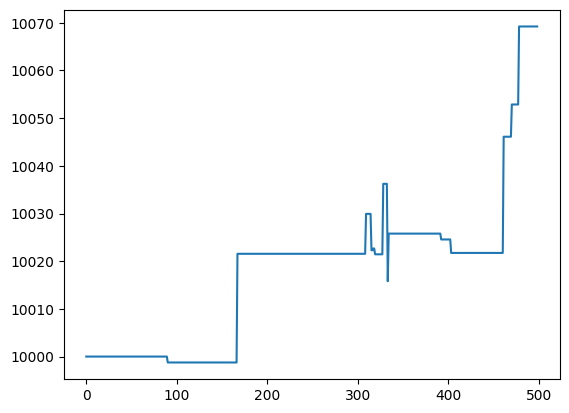

In [88]:
import matplotlib.pyplot as plt

plt.plot(history)

In [ ]:
test_start_dates = [dt.datetime(2024, 7, 10), dt.datetime(2024, 8, 10), dt.datetime(2024, 9, 10), dt.datetime(2024, 10, 10)]

data = FinData("../../datasets/Sber_10_min.csv")

windows_shifts_norms_1 = [2, 3, 4, 5, 6]
windows_ma_1 = [2, 4, 6, 8, 18, 30, 50]
windows_ema_1 = [3, 5, 7, 9, 20, 35, 100]

for start_date in test_start_dates:
    X_train, X_val, X_test, y_train, y_val, y_test = train_valid_test_split(data.df, 
                                                                        dt.datetime(2024, 9, 11), 
                                                                        train_size=3000, 
                                                                        val_size=500, 
                                                                        test_size=500, 
                                                                        numeric=num, cat=cat, target="direction_binary")



    data.insert_shifts_norms(windows_shifts_norms=windows_shifts_norms_1)
    data.insert_rolling_means(windows_ma=windows_ma_1)
    data.insert_exp_rolling_means(windows_ema=windows_ema_1)
    data.insert_bollinger()
    data.insert_rsi()
    data.insert_high_low_diff()
    data.insert_random_prediction()
    num = data.get_numeric_features()
    cat = data.get_cat_features()
    